In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
%matplotlib inline

In [3]:
orig = cv2.imread('1.jpg')

In [4]:
orig.shape

(321, 481, 3)

In [5]:
if len(orig.shape) == 3:
    print("Found 3 Channels : {}".format(orig.shape))
    img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    print("Converted to Gray Channel. Size : {}".format(img.shape))
else:
    img = orig
    print("Image Shape : {}".format(img.shape))

Found 3 Channels : (321, 481, 3)
Converted to Gray Channel. Size : (321, 481)


In [6]:
I = np.asarray(img)
I

array([[218, 216, 216, ..., 158, 159, 156],
       [218, 212, 210, ..., 158, 159, 156],
       [220, 212, 208, ..., 159, 159, 157],
       ...,
       [ 17,  68,  98, ...,  55,  49,  61],
       [  3,  61,  99, ...,  63,  61,  63],
       [  3,  27,  83, ...,  59,  59,  64]], dtype=uint8)

In [7]:
def gaussian1D(size, sigma):
    gaussian = np.zeros((size))
    size = size//2
    
    for x in range(-size, size+1): 
        x1 = np.sqrt( 2.* np.pi * sigma**2 )
        x2=np.exp(-(x**2)/(2*sigma**2))
        gaussian[x+size] = (1/x1)*x2
    return gaussian

In [8]:
G1 = gaussian1D(5,1)
G1 = G1.reshape(1,len(G1))

In [9]:
filter_x_height = G1.shape[0]
filter_x_width = G1.shape[1]

print(filter_x_height)
print(filter_x_width)

1
5


In [10]:
G2 = G1.reshape(filter_x_width,1)

In [11]:
filter_y_height = G2.shape[0]
filter_y_width = G2.shape[1]

print(filter_y_height)
print(filter_y_width)

5
1


In [12]:
def convolution(image, kernel):
    image_h = image.shape[0]
    image_w = image.shape[1]
    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    if(len(image.shape) == 3):
        image_pad = np.pad(image, pad_width=((kernel_h // 2, kernel_h // 2), (kernel_w // 2, kernel_w // 2),(0,0)), mode='constant', constant_values=0).astype(np.float32)
    elif(len(image.shape) == 2):
        image_pad = np.pad(image, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
 
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            #sum = 0
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            x = x.flatten()*kernel.flatten()
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h:,w:w_end]
    
    if(w == 0):
        return image_conv[h:h_end,w:]

    return image_conv[h:h_end,w:w_end]

In [13]:
G1

array([[0.05399097, 0.24197072, 0.39894228, 0.24197072, 0.05399097]])

In [14]:
G2

array([[0.05399097],
       [0.24197072],
       [0.39894228],
       [0.24197072],
       [0.05399097]])

In [15]:
Ix = convolution(img, G1)

In [16]:
Iy = convolution(img, G2)

In [17]:
Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gx

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]])

In [18]:
Gy = np.flip(Gx.T, axis=0)
Gy

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

In [19]:
new_Ix = convolution(Ix, Gx)

In [20]:
new_Iy = convolution(Iy, Gy)

In [21]:
gradient_magnitude = np.sqrt(np.square(new_Ix) + np.square(new_Iy))

In [22]:
gradient_magnitude = gradient_magnitude* 255.0 / gradient_magnitude.max()

In [23]:
gradient_direction = np.arctan2(Iy, Ix)
gradient_direction = np.rad2deg(gradient_direction)
gradient_direction += 180

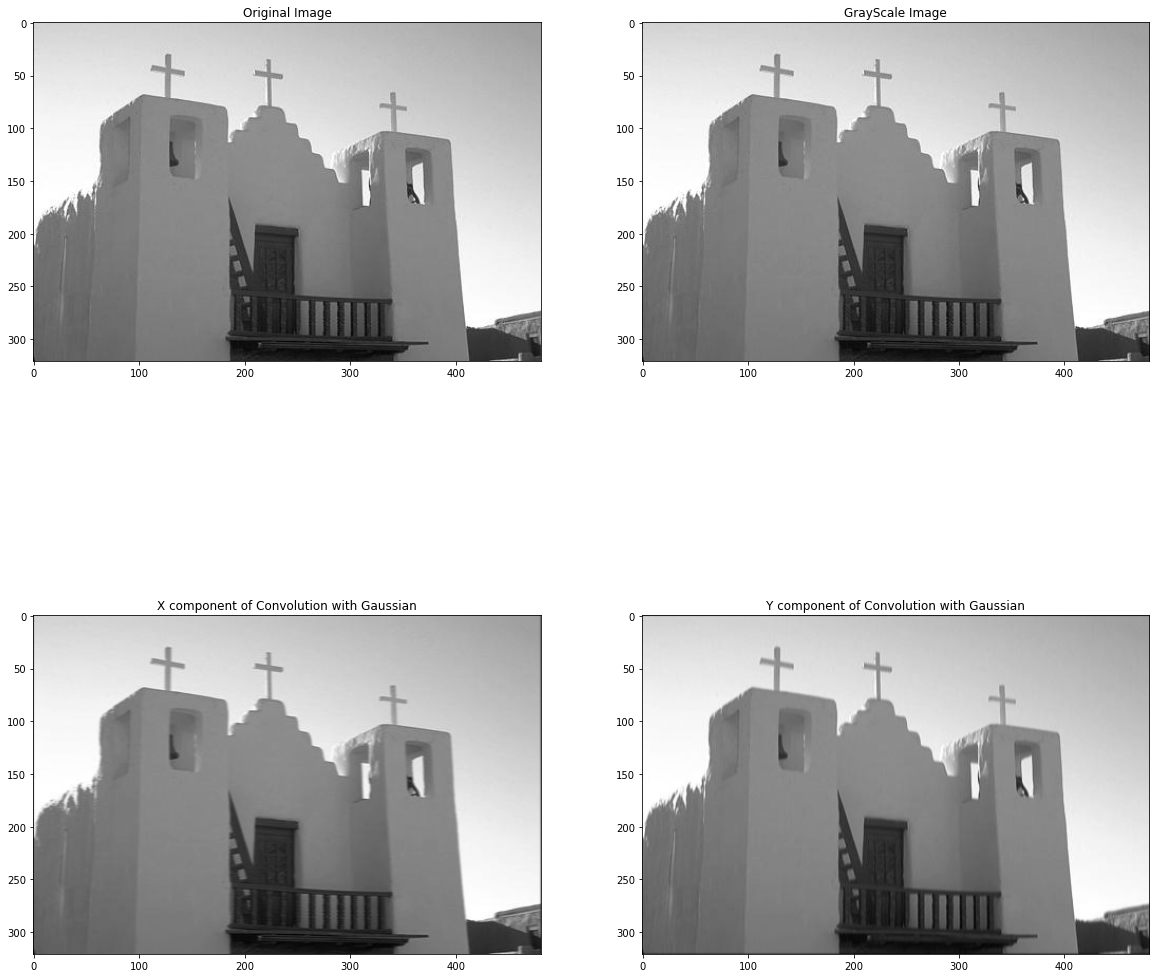

In [24]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(221)
ax.title.set_text('Original Image')
ax.imshow(orig[:,:,::-1])
ax2 = f.add_subplot(222)
ax2.title.set_text('GrayScale Image')
ax2.imshow(I[:,:], cmap="gray")
ax3 = f.add_subplot(223)
ax3.title.set_text('X component of Convolution with Gaussian')
ax3.imshow(Ix[:,:], cmap="gray")
ax4 = f.add_subplot(224)
ax4.title.set_text('Y component of Convolution with Gaussian')
ax4.imshow(Iy[:,:], cmap="gray")

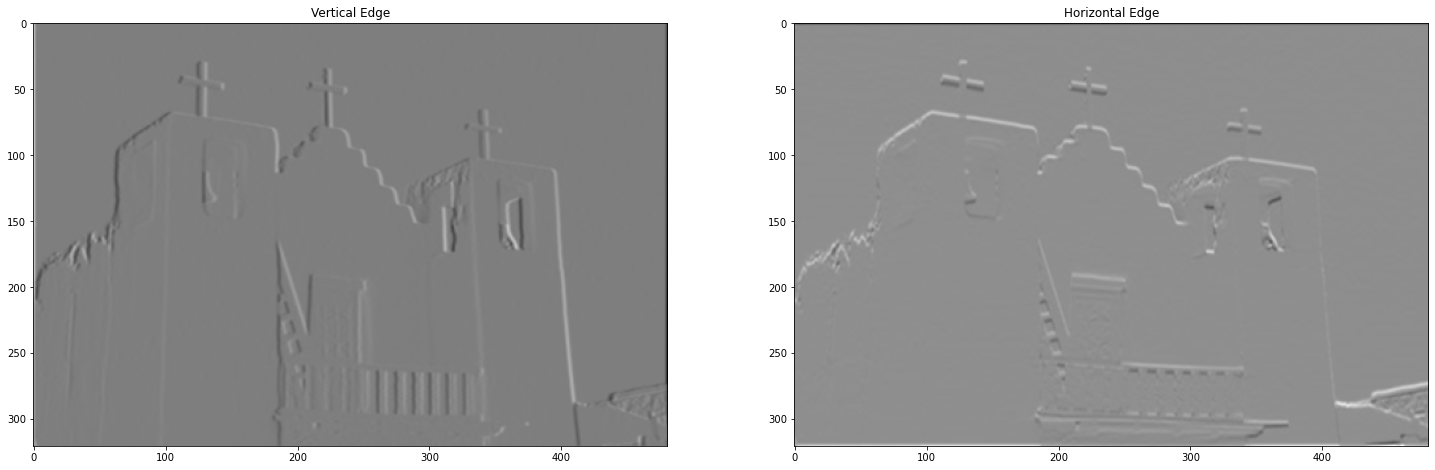

In [25]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(new_Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(new_Iy[:,:], cmap="gray")

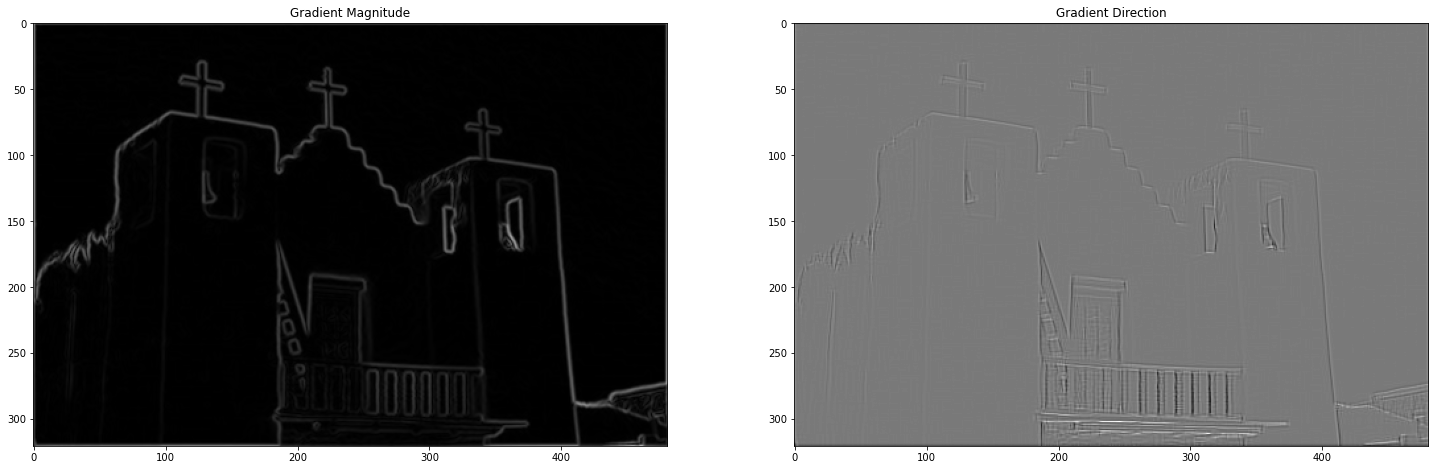

In [26]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Gradient Magnitude')
ax1.imshow(gradient_magnitude[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Gradient Direction')
ax2.imshow(gradient_direction[:,:], cmap="gray")

In [27]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < PI / 4) or (PI <= direction <= 5 * PI / 4):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 4 <= direction <  PI / 2) or (5 * PI / 4 <= direction < 3 * PI / 2):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif ( PI / 2 <= direction < 6 * PI / 8) or (3 * PI / 2 <= direction < 7 * PI / 4):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
          
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
 
    return output
 

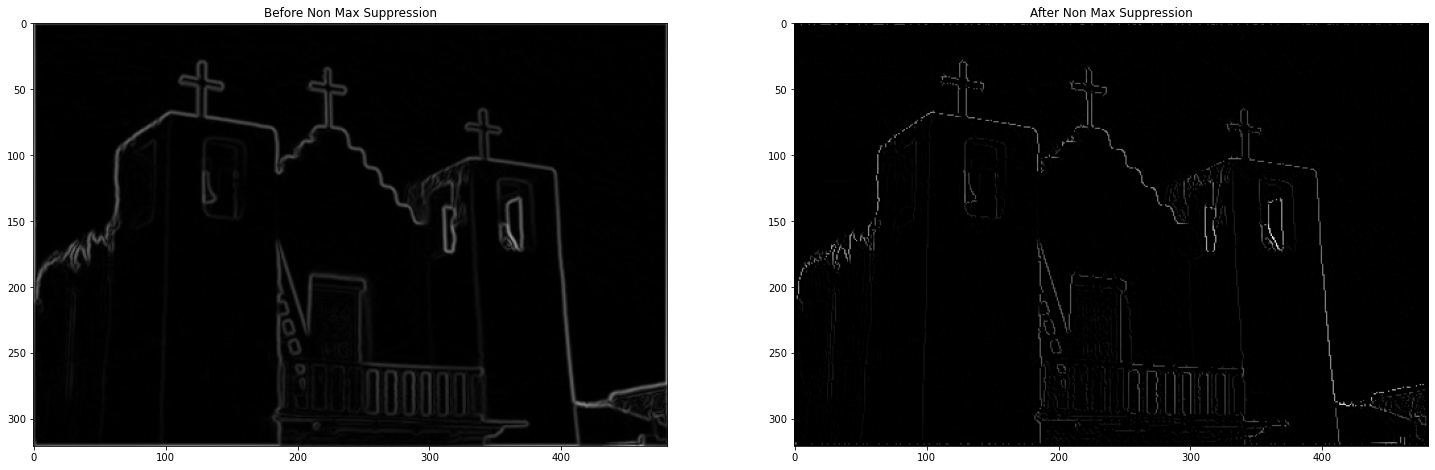

In [28]:
new_image = non_max_suppression(gradient_magnitude, gradient_direction)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
ax.title.set_text('Before Non Max Suppression')
ax.imshow(gradient_magnitude[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('After Non Max Suppression')
ax2.imshow(new_image[:,:], cmap="gray")

In [29]:
def threshold(image, low, high, weak):
    output = np.zeros(image.shape)
 
    strong = 255
 
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak
 
    return output

In [30]:
def hysteresis(image, weak):
    image_row, image_col = image.shape
 
    top_to_bottom = image.copy()
 
    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0
 
    bottom_to_top = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0
 
    right_to_left = image.copy()
 
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0
 
    left_to_right = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0
 
    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
 
    final_image[final_image > 255] = 255
 
    return final_image

In [31]:
weak = 50
 
new_image = threshold(new_image, 5, 20, weak=weak)

new_image = hysteresis(new_image, weak)

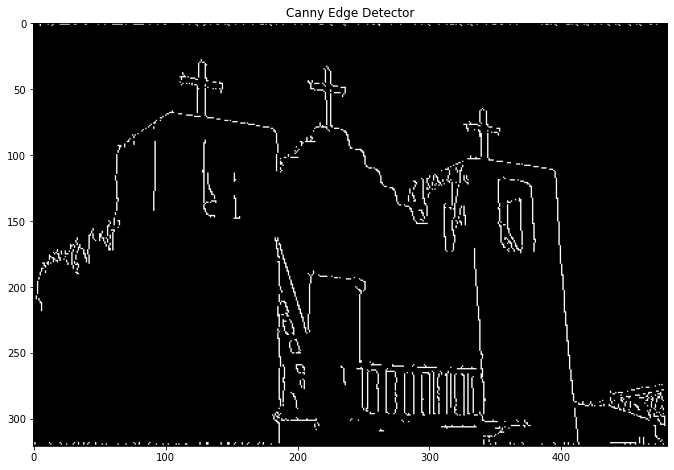

In [32]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
ax.title.set_text('Canny Edge Detector')
ax.imshow(new_image[:,:], cmap="gray")

In [33]:
edges = cv2.Canny(orig,100,200)

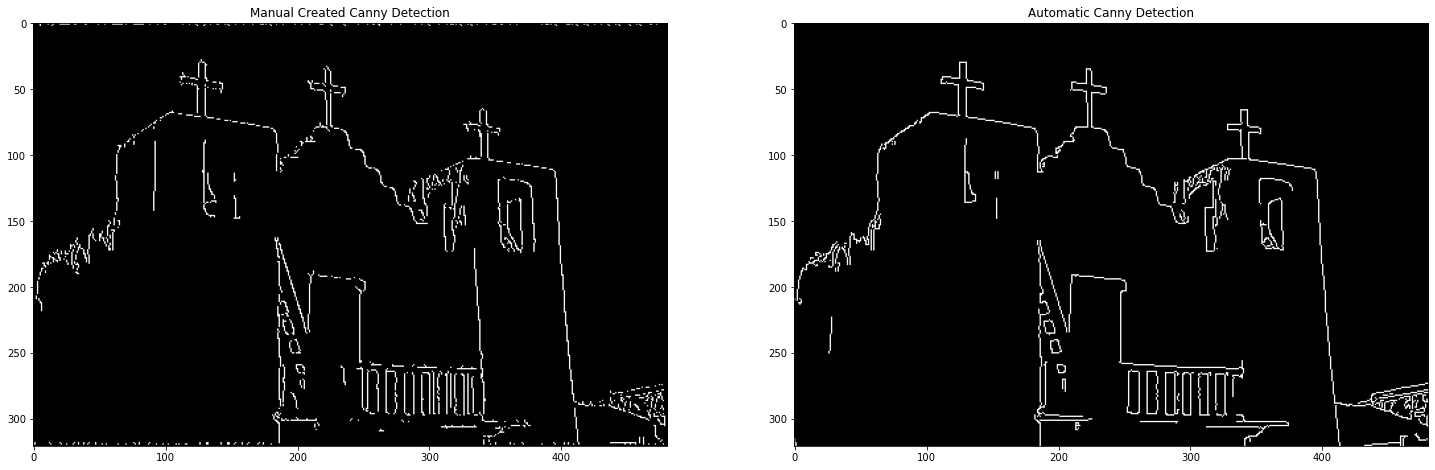

In [34]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
ax.title.set_text('Manual Created Canny Detection')
ax.imshow(new_image[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Automatic Canny Detection')
ax2.imshow(edges[:,:], cmap="gray")